In [2]:
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
import numba
import scipy.optimize
import scipy.signal
from scipy.optimize import leastsq, curve_fit
from scipy.stats import pearsonr
from scipy.signal import hilbert
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.signal import find_peaks
from matplotlib.collections import PolyCollection
# import imageio.v2 as imageio
from PIL import Image
import matplotlib.patches as mpatches
from scipy import integrate
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import math

# Ball-and-stick model

In [35]:
cm        = 1.0e-2   # F/m2 specific membrane capacitance
diam_soma = 15.0e-6  # m somatic diameter
diam_dend = 1.0e-6   # m dendritic diameter
Ld        = 7.0e-4   # m dendritic cable length
rho_m     = 1/3      # S/m2 specific membrane conductance
rho_i     = 1/2      # S/m2 specific internal conductance
delta_T   = 1.5      # mV threshold slope facter
VT        = 10       # mV effective threshold voltage
Vth       = 20       # mV threshold/spike voltage
Vr        = 0        # mV reset voltage

Cs = cm*diam_soma**2*np.pi
Gs = rho_m*diam_soma**2*np.pi
Cm = cm*diam_dend*np.pi
gm = rho_m*diam_dend*np.pi
gi = rho_i*(diam_dend/2)**2*np.pi

In [36]:
AE = 10
fE = np.arange(1, 100, 1)
w = 2*np.pi*fE
zw = np.sqrt((1j*w*Cm + gm)/gi)
Aw = AE*gi*(1/np.cosh(zw*Ld) - 1)/(Cs*1j*w + Gs*(1 - np.exp((Vr-VT)/delta_T)) + zw*gi*np.tanh(zw*Ld))
amp = np.abs(np.real(Aw))*1e3

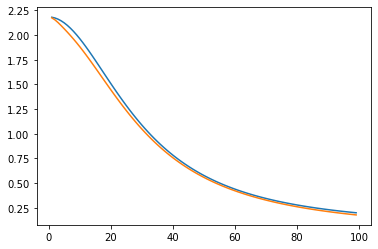

In [37]:
plt.plot(fE, amp)
plt.plot(fE, ampE)

# Two-compatment model

In [80]:
params2C = np.load('data/params2C.npy')
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C
AE = 10
fE = 10
w = 2*np.pi*fE
ys = Cs*1j*w + Gs + Gi
yd = Cd*1j*w + Gd + Gi

Z_Is = 1 / (ys - Gi**2/yd)
Z_Id = Z_Is*Gi/yd
Z_E  = Gi*Delta*(Z_Id - Z_Is)

ampIs = AE*np.abs(Z_Is)*1e3*Gi*Delta
phiIs = np.angle(Z_Is)
ampId = AE*np.abs(Z_Id)*1e3*Gi*Delta
phiId = np.angle(Z_Id) + 4*np.pi/4
ampE  = AE*np.abs(np.real(Z_E))*1e3

In [90]:
'''不同刺激强度下，soma极化幅值'''
list_AE = np.arange(0, 21, 2.5)
list_ApSoma, list_ApDend = np.zeros_like(list_AE), np.zeros_like(list_AE)
list_phipSoma, list_phipDend = np.zeros_like(list_AE), np.zeros_like(list_AE)
for i in range(len(list_AE)):
    AE = list_AE[i]
    fE = 10
    w  = 2*np.pi*fE
    ys = Cs*1j*w + Gs + Gi
    yd = Cd*1j*w + Gd + Gi
    Z_Is = 1 / (ys - Gi**2/yd)
    Z_Id = Z_Is*Gi/yd
    Z_E  = Gi*Delta*(Z_Id - Z_Is)
    ampIs = AE*Gi*Delta*np.abs(Z_Is)*1e3
    phiIs = np.angle(Z_Is)
    ampId = AE*Gi*Delta*np.abs(Z_Id)*1e3
    phiId = np.angle(Z_Id)
    phiIs, phiId = np.rad2deg(phiIs), np.rad2deg(phiId)
    list_ApSoma[i], list_ApDend[i] = ampIs, ampId
    list_phipSoma[i], list_phipDend[i] = phiIs, phiId

Text(0, 0.5, 'Somatic φp (°)')

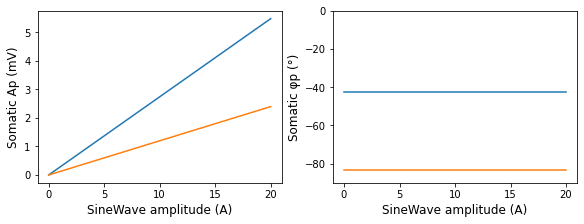

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
ax0, ax1 = ax
ax0.plot(list_AE, list_ApSoma)
ax0.plot(list_AE, list_ApDend)
ax1.plot(list_AE, list_phipSoma)
ax1.plot(list_AE, list_phipDend)
ax1.set_ylim(-90, 0)

ax0.set_xlabel('SineWave amplitude (A)', fontsize=12)
ax1.set_xlabel('SineWave amplitude (A)', fontsize=12)
ax0.set_ylabel('Somatic Ap (mV)', fontsize=12)
ax1.set_ylabel('Somatic φp (°)', fontsize=12)

In [131]:
'''不同刺激频率下，soma极化幅值'''
list_fE = np.arange(1, 100.0, 0.1)
list_ApSoma, list_ApDend = np.zeros_like(list_fE), np.zeros_like(list_fE)
list_phipSoma, list_phipDend = np.zeros_like(list_fE), np.zeros_like(list_fE)
list_sumAp = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE = 10
    fE = list_fE[i]
    w  = 2*np.pi*fE
    ys = Cs*1j*w + Gs + Gi
    yd = Cd*1j*w + Gd + Gi
    Z_Is = 1 / (ys - Gi**2/yd)
    Z_Id = Z_Is*Gi/yd
    Z_E  = Gi*Delta*(Z_Id - Z_Is)
    ampIs = AE*Gi*Delta*np.abs(Z_Is)*1e3
    phiIs = np.angle(Z_Is) + 1*np.pi
    ampId = AE*Gi*Delta*np.abs(Z_Id)*1e3
    phiId = np.angle(Z_Id)
    list_sumAp[i] = np.sqrt(ampIs**2 + ampId**2 + 2*ampIs*ampId*np.cos(phiIs-phiId))
    phiIs, phiId = np.rad2deg(phiIs), np.rad2deg(phiId)
    list_ApSoma[i], list_ApDend[i] = ampIs, ampId
    list_phipSoma[i], list_phipDend[i] = phiIs, phiId

Text(0, 0.5, 'Somatic φp (°)')

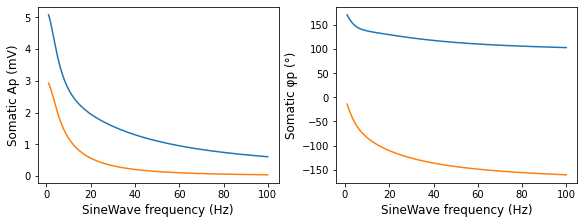

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
ax0, ax1 = ax
ax0.plot(list_fE, list_ApSoma)
ax0.plot(list_fE, list_ApDend)
ax1.plot(list_fE, list_phipSoma)
ax1.plot(list_fE, list_phipDend)
# ax1.set_ylim(-180, 0)

ax0.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax1.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax0.set_ylabel('Somatic Ap (mV)', fontsize=12)
ax1.set_ylabel('Somatic φp (°)', fontsize=12)

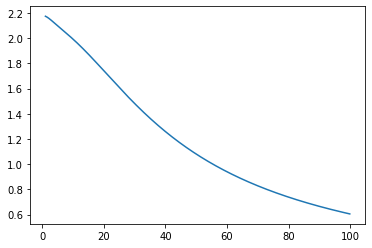

In [133]:
plt.plot(list_fE, list_sumAp)

In [132]:
t = np.arange(0, 1, 0.01/1e3)
fE = np.arange(1, 100, 1)
list_sinIs, list_sinId = [], []
listIsId = []
for i in range(99):
    amp1, phi1, f1 = ampIs[i], phiIs[i], fE[i]
    sinIs = amp1*np.sin(2*np.pi*f1*t + phi1)
    amp2, phi2, f2 = ampId[i], phiId[i], fE[i]
    sinId = amp2*np.sin(2*np.pi*f2*t + phi2)
    # tempphi = np.arccos((amp1 + amp2*np.cos(phi2-phi1)) / np.sqrt(amp1**2 + amp2**2 + 2*amp1*amp2*np.cos(phi2-phi1)))
    # sinIsId = np.sqrt(amp1**2 + amp2**2 + 2*amp1*amp2*np.cos(phi2-phi1)) * np.sin(2*np.pi*f1*t + phi1 + tempphi)
    # list_sinIs.append(phi2-phi1)
    listIsId.append(np.sqrt(amp1**2 + amp2**2 + 2*amp1*amp2*np.cos(phi2-phi1)))

# Simulation

In [4]:
import os, subprocess
def svg_to_emf(svg_figpath):
    '''1. 如果是.svg的绝对路径，True改为False；
       2. inlscape.exe的文件路径中必须是双斜杠\\，单斜杠\会出错；
       3. subprocess.call中的shell=True不可省略，否则会报错。'''
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        os.remove(svg_figpath)

def powerfit(x, ain1, bin1, cin1):
        return ain1*x**bin1 + cin1

def poly2fit(x, p1, p2, p3):
    y = p1*x**2 + p2*x + p3
    return y
def poly3fit(x, p1, p2, p3, p4):
    y = p1*x**3 + p2*x**2 + p3*x + p4
    return y
    

def poly1fit(x, p1, p2):
    y = p1*x + p2
    return y

def poly5fit(x, p1, p2, p3, p4, p5, p6):
    y = p1*x**5 + p2*x**4 + p3*x**3 + p4*x**2 + p5*x + p6
    return y
def poly4fit(x, p1, p2, p3, p4, p5):
    y = p1*x**4 + p2*x**3 + p3*x**2 + p4*x + p5
    return y

def gauss2fit(x, a1, b1, c1, a2, b2, c2):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2)
    return y
def gauss3fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2)
    return y
def gauss4fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2) + a4*np.exp(-((x-b4)/c4)**2)
    return y

def exp2fit(x, a, b, c, d):
    y = a*np.exp(b*x) + c*np.exp(d*x)
    return y


@numba.njit
def generateOUNoise_Liu(tvar): 
    tau_OU = 5 # 5ms
    OUNoise = np.zeros_like(tvar)
    dt1 = tvar[1] - tvar[0] # ms
    for i in range(len(OUNoise)-1):
        OUNoise[i+1] = OUNoise[i] - (OUNoise[i]/tau_OU)*dt1 + np.sqrt(dt1)*np.sqrt(2/tau_OU)*np.random.randn()   
    return OUNoise
    
def calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=19.0):
    '''峰值时刻作为放电时刻'''
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore) # 逻辑与，上述两者逻辑与为真代表为局部最大值，是放电峰值可能存在的时刻
    largerThanThresh = vsoma > Vth  # 定义一个远大于放电阈值的电压值
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) # 放电峰值时刻二进制序列
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]
    firingRate = 1e3 * spikeNumber / (tvar[-1] - tvar[0])
    return spikeNumber, firingRate, spikeInds, outputSpikeTimes

def calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0):
    dt = tvar[1] - tvar[0]
    nDtPer1ms = int(1/dt)
    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence1 = np.sum(spikeCountSequence, axis=1)

    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence2 = np.sum(spikeCountSequence, axis=1)
    
    outputCorrelation   = pearsonr(spikeCountSequence1, spikeCountSequence2)[0]
    return outputCorrelation

def calcTacsSpikePLV(vsoma, Evar, tvar, Vth=19.0):
    '''采用希尔伯特变换, 0°对应了电场波形的峰值, 90°对应了电场下降边缘'''
    analyticSignal = hilbert(Evar)
    tacsInstantaneousPhase = np.angle(analyticSignal)  # 计算结果为弧度值,-π~π
    _, _, spikeIndex, spikeTime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=Vth)
    spikePhaseRadian = tacsInstantaneousPhase[spikeIndex]
    spikePhaseRadian[spikePhaseRadian < 0 ] += 2*np.pi
    pluralPLV = np.mean(np.exp(1j*spikePhaseRadian))
    spikePhaseDegree = np.rad2deg(spikePhaseRadian)
    fieldSpikePLV = np.abs(pluralPLV)
    
    return fieldSpikePLV, spikePhaseDegree, pluralPLV

'''
Paper: Weak electric fields promote resonance in neuronal spiking activity: Analytical results from two-compartment cell and network models
'''
@numba.njit
def twoCompModel(params2C, vs, vd, Is=0.0, Id=0.0, E=0.0, dt=0.1):
    # Cs, Cd, Gs, Gd, Gi = params2C['Cs'], params2C['Cd'], params2C['Gs'], params2C['Gd'], params2C['Gj']
    # Gexp, DeltaT, VT   = params2C['Gexp'], params2C['DeltaT'], params2C['VT']
    # # Vr, Vth            = params2C['Vr'], params2C['Vth']
    # Delta, DeltaV      = params2C['Delta'], params2C['DeltaV']
    Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV = params2C
    vsn = vs + dt * ( Gi*(vd-vs-Delta*E) - Gs*vs + Is + Gexp*DeltaT*np.exp((vs-VT)/DeltaT)) / Cs
    vdn = vd + dt * (-Gi*(vd-vs-Delta*E) - Gd*vd + Id) / Cd
    return vsn, vdn
    
@numba.njit
def runModel(params2C=np.ones(1), dt=0.01, tvar=0., Is=0.0, Id=0.0, Evar=0.0):
    Vr, Vth  = params2C[-2], params2C[-1]
    vs, vd   = 0, 0
    vsoma, vdend = np.zeros_like(tvar), np.zeros_like(tvar)
    for i, t in enumerate(tvar):
        vs, vd = twoCompModel(params2C[0:-2], vs, vd, Is=Is[i], Id=Id[i], E=Evar[i], dt=dt)
        if vs > Vth:
            vs = Vr
        vsoma[i], vdend[i] = vs, vd
        
    return vsoma, vdend

params2C = np.load('data/params2C.npy')
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C

## 树突正弦刺激作用

In [139]:
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_AE  = np.arange(0, 20+1, 2.5)
list_ApSoma = np.zeros_like(list_AE)
for i in range(len(list_AE)):
    AE, fE, phiE   = list_AE[i], 10, 0   
    if AE > 0:
        Id = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
        Is = np.zeros_like(tvar)    
        Evar = np.zeros_like(tvar)    
        vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
        vsoma = vsoma*1e3
        lastPeakIndex = find_peaks(vsoma)[0][-1]
        list_ApSoma[i] = vsoma[lastPeakIndex]
# np.savez('data/dendSineAmp0-20_Freq10.npz', list_AE=list_AE, list_Ap=list_ApSoma)

Text(0, 0.5, 'Somatic Ap (mV)')

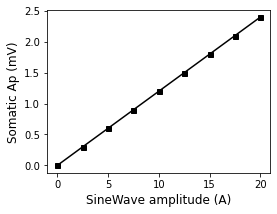

In [140]:
data = np.load('data/dendSineAmp0-20_Freq10.npz')
list_AE, list_ApSoma = data['list_AE'], data['list_Ap']
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_AE, list_ApSoma, marker='s', ms=5, color='k', lw=1.5)
ax.set_xlabel('SineWave amplitude (A)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

In [141]:
%%time
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_fE  = np.arange(1, 101.0, 1)
list_ApSoma = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE, fE, phiE   = 10, list_fE[i], 0   
    Id = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
    Is = np.zeros_like(tvar)    
    Evar = np.zeros_like(tvar)    
    vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    vsoma = vsoma*1e3
    lastPeakIndex = find_peaks(vsoma)[0][-1]
    list_ApSoma[i] = vsoma[lastPeakIndex]

# np.savez('data/dendSineAmp10_Freq1-100.npz', list_fE=list_fE, list_Ap=list_ApSoma)

Wall time: 2.37 s


Text(0, 0.5, 'Somatic Ap (mV)')

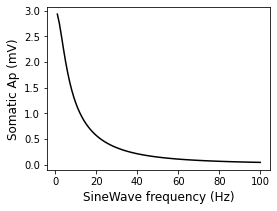

In [143]:
data = np.load('data/dendSineAmp10_Freq1-100.npz')
list_fE, list_ApSoma = data['list_fE'], data['list_Ap']
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_fE, list_ApSoma, color='k', lw=1.5)
ax.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

## 胞体正弦刺激作用

In [144]:
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_AE  = np.arange(0, 20+1, 2.5)
list_ApDend = np.zeros_like(list_AE)
for i in range(len(list_AE)):
    AE, fE, phiE   = list_AE[i], 10, 0   
    if AE > 0:
        Is = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
        Id = np.zeros_like(tvar)    
        Evar = np.zeros_like(tvar)    
        vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
        vsoma = vsoma*1e3
        lastPeakIndex = find_peaks(vsoma)[0][-1]
        list_ApDend[i] = vsoma[lastPeakIndex]
# np.savez('data/somaSineAmp0-20_Freq10.npz', list_AE=list_AE, list_Ap=list_ApDend)

Text(0, 0.5, 'Somatic Ap (mV)')

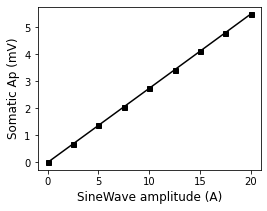

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_AE, list_ApDend, marker='s', ms=5, color='k', lw=1.5)
ax.set_xlabel('SineWave amplitude (A)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

In [145]:
%%time
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_fE  = np.arange(1, 101.0, 1)
list_ApDend = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE, fE, phiE   = 10, list_fE[i], 0   
    Is = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
    Id = np.zeros_like(tvar)    
    Evar = np.zeros_like(tvar)    
    vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    vsoma = vsoma*1e3
    lastPeakIndex = find_peaks(vsoma)[0][-1]
    list_ApDend[i] = vsoma[lastPeakIndex]
# np.savez('data/somaSineAmp10_Freq1-100.npz', list_fE=list_fE, list_Ap=list_ApDend)

Wall time: 2.36 s


Text(0, 0.5, 'Somatic Ap (mV)')

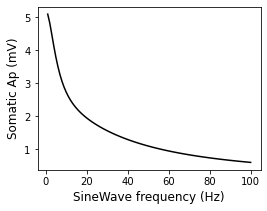

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_fE, list_ApDend, color='k', lw=1.5)
ax.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

## 胞体和树突分别正弦刺激作用

In [148]:
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_AE  = np.arange(0, 20+1, 2.5)
list_Ap  = np.zeros_like(list_AE)
for i in range(len(list_AE)):
    AE, fE, phiE   = list_AE[i], 10, 0   
    if AE > 0:
        Id = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
        Is = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE + np.pi)
        Evar = np.zeros_like(tvar)    
        vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
        vsoma = vsoma*1e3
        lastPeakIndex = find_peaks(vsoma)[0][-1]
        list_Ap[i] = vsoma[lastPeakIndex]
# np.savez('data/somadendSineAmp0-20_Freq10.npz', list_AE=list_AE, list_Ap=list_Ap)

Text(0, 0.5, 'Somatic Ap (mV)')

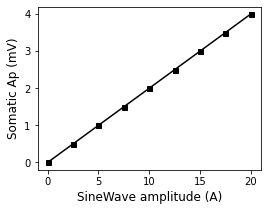

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_AE, list_Ap, marker='s', ms=5, color='k', lw=1.5)
ax.set_xlabel('SineWave amplitude (A)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

In [17]:
%%time
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_fE  = np.arange(1, 101.0, 5)
list_Ap  = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE, fE, phiE   = 10, list_fE[i], 0   
    Id = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE + np.pi)
    Is = Gi * Delta * AE * np.sin(2 * np.pi * fE * tvar + phiE)
    Evar = np.zeros_like(tvar)    
    vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    vsoma = vsoma*1e3
    lastPeakIndex = find_peaks(vsoma)[0][-1]
    list_Ap[i] = vsoma[lastPeakIndex]
# np.savez('data/somadendSineAmp10_Freq1-100.npz', list_fE=list_fE, list_Ap=list_Ap)

Wall time: 609 ms


Text(0, 0.5, 'Somatic Ap (mV)')

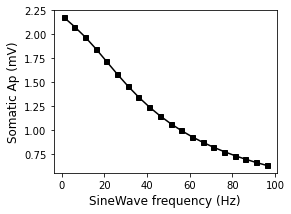

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_fE, list_Ap, marker='s', ms=5, color='k', lw=1.5)
ax.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

## 电场作用

In [20]:
%%time
dt       = 0.01/1e3               
duration = 5                       
tvar     = np.arange(0, duration, dt) 

list_fE  = np.arange(1, 101.0, 5)
list_Ap1  = np.zeros_like(list_fE)
for i in range(len(list_fE)):
    AE, fE, phiE   = 10, list_fE[i], 0   
    Id = np.zeros_like(tvar)
    Is = np.zeros_like(tvar)
    Evar = AE * np.sin(2 * np.pi * fE * tvar + phiE) 
    vsoma, _ = runModel(params2C=params2C, dt=dt, tvar=tvar, Is=Is, Id=Id, Evar=Evar)
    vsoma = vsoma*1e3
    lastPeakIndex = find_peaks(vsoma)[0][-1]
    list_Ap1[i] = vsoma[lastPeakIndex]
# np.savez('data/EfieldAmp10_Freq1-100.npz', list_fE=list_fE, list_Ap=list_Ap)

Wall time: 487 ms


Text(0, 0.5, 'Somatic Ap (mV)')

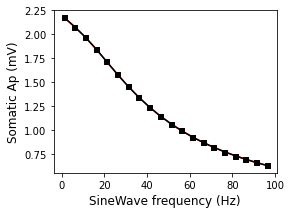

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(list_fE, list_Ap, marker='s', ms=5, color='r', lw=1.5)
ax.plot(list_fE, list_Ap1, marker='s', ms=5, color='k', lw=1.5)
ax.set_xlabel('SineWave frequency (Hz)', fontsize=12)
ax.set_ylabel('Somatic Ap (mV)', fontsize=12)

# Figure 7: 电场改变了输入相关性

In [ ]:
data = np.load('data/dendSineAmp0-20_Freq10.npz')
list_AE, list_ApSoma = data['list_AE'], data['list_Ap']

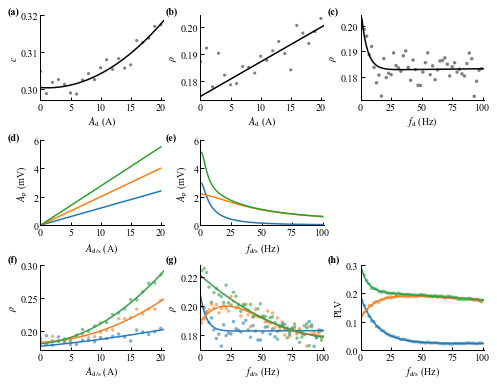

In [260]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#247AB7', '#F47E1F', '#30A04A']
fig, ax = plt.subplots(3, 3, figsize=(7, 5.4))

list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
'''Figure 7(a): 正弦刺激改变输入相关性'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy')
data = data.squeeze().mean(axis=0).transpose()
data_c = data[0]
xfit   = np.arange(0, 20.5, 0.01)
yfit   = poly2fit(xfit, *[4.799e-5, -0.0001067, 0.3004])
ax[0, 0].scatter(list_AE, data_c, s=10, ec=None, fc='grey')
ax[0, 0].plot(xfit, yfit, color='k', lw=1.5)

ax[0, 0].set_ylim(0.297, 0.32)

'''Figure 7(b): 输出相关性依赖于刺激强度'''
data_rou = data[2]
xfit   = np.arange(0, 20.5, 0.01)
yfit   = poly1fit(xfit, *[0.001283, 0.1744])
ax[0, 1].scatter(list_AE, data_rou, s=10, ec=None, fc='grey')
ax[0, 1].plot(xfit, yfit, color='k', lw=1.5)

# ax[0, 1].set_ylim(0.297, 0.32)



'''Figure 7(c): 输出相关性依赖于刺激频率'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy')
data = data.squeeze().mean(axis=0).transpose()
data_rou = data[2]
xfit   = np.arange(1, 100.5, 0.1)
yfit   = exp2fit(xfit, *[0.02485, -0.2023, 0.1826, 3.028e-5])

ax[0, 2].scatter(list_fE, data_rou, s=12, ec=None, fc='grey')
ax[0, 2].plot(xfit, yfit, color='k', lw=1.5)

'''Figure 7(d): 响应幅值依赖于刺激强度'''
addr = ['data/dendSineAmp0-20_Freq10.npz', 'data/somadendSineAmp0-20_Freq10.npz', 'data/somaSineAmp0-20_Freq10.npz']
for tempaddr in addr:
    data = np.load(tempaddr)
    list_AE, list_Ap = data['list_AE'], data['list_Ap']
    ax[1, 0].plot(list_AE, list_Ap)



'''Figure 7(e): 响应幅值依赖于刺激频率'''
addr = ['data/dendSineAmp10_Freq1-100.npz', 'data/somadendSineAmp10_Freq1-100.npz', 'data/somaSineAmp10_Freq1-100.npz']
for tempaddr in addr:
    data = np.load(tempaddr)
    list_fE, list_Ap = data['list_fE'], data['list_Ap']
    ax[1, 1].plot(list_fE, list_Ap)




'''Figure 7(f): 输出相关性依赖于刺激强度'''
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy']
paras = [[1.733e-5, 0.0008905, 0.1762], [0.0001404, 0.0003203, 0.1823], [0.000223, 0.0008241, 0.1799]]
xfit = np.arange(0, 21, 0.1)
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    yfit = poly2fit(xfit, *paras[i])
    ax[2, 0].scatter(list_AE, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
    ax[2, 0].plot(xfit, yfit, color=colors[i], zorder=1, lw=1.5)

'''Figure 7(g): 输出相关性依赖于刺激频率'''
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy']
xfit = np.arange(0, 101, 0.5)
yfit = []
yfit.append(exp2fit(xfit, *[0.02485, -0.2023, 0.1826, 3.028e-5]))
yfit.append(poly4fit(xfit, *[-1.258e-9, 3.762e-7, -3.736e-5, 0.001131, 0.1895]))
yfit.append(poly2fit(xfit, *[3.062e-6, -0.0007302, 0.2211]))
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    ax[2, 1].scatter(list_fE, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
    ax[2, 1].plot(xfit, yfit[i], color=colors[i], zorder=1, lw=1.5)


'''Figure 7(h): PLV依赖于刺激频率'''
xfit = np.arange(0, 101, 0.5)
yfit = []
yfit.append(exp2fit(xfit, *[0.163, -0.07286, 0.02392, -0.0004041]))
yfit.append(exp2fit(xfit, *[0.2086, -0.001764, -0.0945, -0.07626]))
yfit.append(exp2fit(xfit, *[0.08848, -0.1797, 0.2074, -0.001602]))
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_plv = data[3]
    ax[2, 2].scatter(list_fE, data_plv, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
    ax[2, 2].plot(xfit, yfit[i], color=colors[i], zorder=1, lw=1.5)

ax[2, 2].set_ylim(0, 0.3)


for item in [ax[0,0], ax[0,1], ax[1,0], ax[2,0]]:
    item.set_xlim(0, 20.5)
    item.set_xticks(np.arange(0, 21, 5))

for item in [ax[0,2], ax[1,1], ax[2,1], ax[2,2]]:
    item.set_xlim(0, 101)
    item.set_xticks(np.arange(0, 101, 25))

for item in [ax[1,0], ax[1,1]]:
    item.set_ylim(0, 6)
    item.set_yticks([0, 2, 4, 6])

for item in [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[2,0], ax[2,1], ax[2,2]]:
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)

for i in range(3):
    for j in range(3):
        ax[i, j].tick_params(pad=2)

ax[1, 2].axis('off')
# ax[2, 2].axis('off')

ax[0, 0].set_xlabel(r'$\mathit{A}_{\mathrm{d}}$ (A)', fontsize=10, labelpad=2)
ax[0, 0].set_ylabel(r'$c$', fontsize=10, labelpad=2)
ax[0, 1].set_xlabel(r'$\mathit{A}_{\mathrm{d}}$ (A)', fontsize=10, labelpad=2)
ax[0, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax[0, 2].set_xlabel(r'$\mathit{f}_{\mathrm{d}}$ (Hz)', fontsize=10, labelpad=2)
ax[0, 2].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)


ax[1, 0].set_xlabel(r'$\mathit{A}_{\mathrm{d/s}}$ (A)', fontsize=10, labelpad=4)
ax[1, 0].set_ylabel(r'$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=4)
ax[1, 1].set_xlabel(r'$\mathit{f}_{\mathrm{d/s}}$ (Hz)', fontsize=10, labelpad=4)
ax[1, 1].set_ylabel(r'$\mathit{A}_{\mathrm{p}}$ (mV)', fontsize=10, labelpad=4)

ax[2, 0].set_xlabel(r'$\mathit{A}_{\mathrm{d/s}}$ (A)', fontsize=10, labelpad=2)
ax[2, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax[2, 1].set_xlabel(r'$\mathit{f}_{\mathrm{d/s}}$ (Hz)', fontsize=10, labelpad=2)
ax[2, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax[2, 2].set_xlabel(r'$\mathit{f}_{\mathrm{d/s}}$ (Hz)', fontsize=10, labelpad=2)
ax[2, 2].set_ylabel(r'PLV', fontsize=10, labelpad=2)

plt.tight_layout(w_pad=0.2, h_pad=0.6)
fig.text(0.020, 0.965, '(a)', fontsize=10, fontweight='bold')
fig.text(0.335, 0.965, '(b)', fontsize=10, fontweight='bold')
fig.text(0.655, 0.965, '(c)', fontsize=10, fontweight='bold')
fig.text(0.020, 0.64, '(d)', fontsize=10, fontweight='bold')
fig.text(0.335, 0.64, '(e)', fontsize=10, fontweight='bold')
fig.text(0.020, 0.325, '(f)', fontsize=10, fontweight='bold')
fig.text(0.335, 0.325, '(g)', fontsize=10, fontweight='bold')
fig.text(0.655, 0.325, '(h)', fontsize=10, fontweight='bold')

plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure7.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')

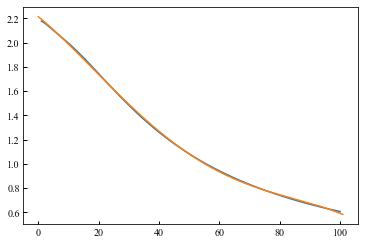

In [303]:
data = np.load('data/somadendSineAmp10_Freq1-100.npz')
list_fE, list_Ap = data['list_fE'], data['list_Ap']
xfit = np.arange(0, 101, 0.1)
yfit = poly4fit(xfit, *[-3.038e-8, 6.278e-6, -0.0002814, -0.02048, 2.214])
plt.plot(list_fE, list_Ap)
plt.plot(xfit, yfit)

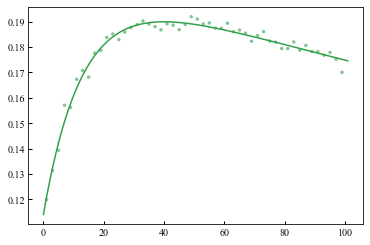

In [304]:
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
xfit = np.arange(0, 101, 0.1)
yfit1 = exp2fit(xfit, *[0.2086, -0.001764, -0.0945, -0.07626])
data = np.load('data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy')
data = data.squeeze().mean(axis=0).transpose()
data_rou = data[2]
data_plv = data[3]
plt.scatter(list_fE, data_plv, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
plt.plot(xfit, yfit1, color=colors[i], zorder=1, lw=1.5)

In [305]:
yfitNorm = (yfit-yfit.min())/(yfit.max()-yfit.min())
yfitNorm1 = (yfit1-yfit1.min())/(yfit1.max()-yfit1.min())
yfitNormAdd = yfitNorm+yfitNorm1

x, y = xfit, yfitNormAdd
init_values = [0.01 for i in range(6)]
best_vals, covar = curve_fit(gauss2fit, x, y, p0=init_values, maxfev = 1000000)
yfitnew  = gauss2fit(xfit, *best_vals)
list_fE = np.arange(1, 100, 2)
roufit = gauss2fit(list_fE, *best_vals)

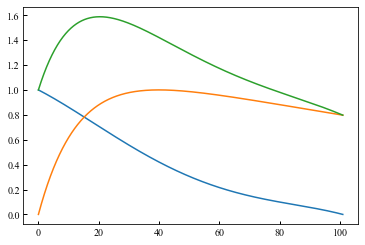

In [306]:
plt.plot(xfit, yfitNorm)
plt.plot(xfit, yfitNorm1)
plt.plot(xfit, yfitNormAdd)
# plt.scatter(xfit, yfitnew)

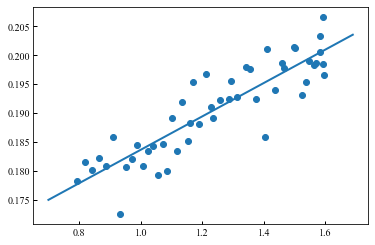

In [307]:

x, y = roufit, data_rou
init_values = [0.1 for i in range(2)]
best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
xfit = np.arange(0.7, 1.7, 0.01)
yfit  = poly1fit(xfit, *best_vals)


plt.scatter(roufit, data_rou)
plt.plot(xfit, yfit, lw=2)


# Lurkum model: 正弦刺激增加输入相关性

In [ ]:
%%time
dt = 0.025
duration = 50e3
tvar = np.arange(0, duration, dt)
mu, sigma, c = 0.3, 0.2, 0.3
list_AE = np.arange(0, 61, 3)*1e-3
data_c  = np.zeros((30, len(list_AE)))
for i in range(30):
    for j in range(len(list_AE)):
        AE, fE, phiE = list_AE[j], 10, 0
        Isin = AE * np.sin(2 * np.pi * fE * tvar / 1e3 + phiE)
        Idc = generateOUNoise_Liu(tvar) * sigma * np.sqrt(c) + mu
        Id1 = generateOUNoise_Liu(tvar) * sigma * np.sqrt(1 - c) + Idc + Isin
        Id2 = generateOUNoise_Liu(tvar) * sigma * np.sqrt(1 - c) + Idc + Isin
        data_c[i, j] = pearsonr(Id1, Id2)[0]
# np.savez('data/LurkumModel_inputcorrelation_30times_Asin0-60pA.npz', list_AE=list_AE, data_c=data_c)

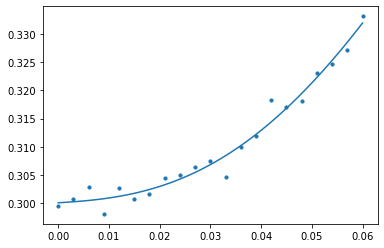

In [27]:
data = np.load('data/LurkumModel_inputcorrelation_30times_Asin0-60pA.npz')
list_AE, data_c = data['list_AE'], data['data_c']

xfit = np.arange(0, 61, 1)*1e-3
yfit = poly4fit(xfit, *[-1034, 166.4, 1.697, 0.05213, 0.3001])
plt.scatter(list_AE, data_c.mean(axis=0), s=10)
plt.plot(xfit, yfit)